# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [2]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
event = 'Indy500'

inputfile = 'C_'+ event +'-' + year + '-final.csv'
outputprefix = year +'-' + event + '-'
dataset = pd.read_csv(inputfile)
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18500 entries, 0 to 18499
Data columns (total 21 columns):
rank                    18500 non-null int64
car_number              18500 non-null int64
unique_id               18500 non-null object
completed_laps          18500 non-null int64
elapsed_time            18500 non-null float64
last_laptime            18500 non-null float64
lap_status              18500 non-null object
best_laptime            18500 non-null float64
best_lap                18500 non-null object
time_behind_leader      18500 non-null float64
laps_behind_leade       18500 non-null object
time_behind_prec        18500 non-null float64
laps_behind_prec        18500 non-null object
overall_rank            18500 non-null object
overall_best_laptime    18500 non-null float64
current_status          18500 non-null object
track_status            18500 non-null object
pit_stop_count          18500 non-null object
last_pitted_lap         18500 non-null object
start_position

### The Problem

According to the document of the log protocols, we have information on rank as below:

+ "Race results are based on laps led and crossing order." (Results protocol definition)
+ "Rank based on best time or race position, updated at each timeline during race" (\$O overall results)



To understand the relationship between rank and elapsed time, we have the following assumptions:

1. Rank is calculated by the elapsed time when car crosses the start-finish line. The order of the cars for the same lap number is its rank.
2. Indy500 have multiple sections (timelines), therefore, rank of a car may change during one lap.





#### laptime analysis

In [4]:
# the lap gap between the cars
#
# in the final lap, the gap is only 1
#
','.join([str(x) for x in dataset.completed_laps])

'0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,1,2,2,1,1,2,2,1,2,2,2,1,2,1,2,2,1,2,2,1,2,2,2,1,2,2,1,1,2,2,1,1,1,2,2,1,1,1,2,2,2,2,2,1,2,2,2,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,3,3,3,2,3,3,2,3,2,3,3,2,3,2,3,2,2,3,3,2,3,3,3,3,2,3,3,2,3,3,2,3,3,2,3,2,3,3,2,3,3,3,3,2,3,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,3,4,4,4,3,4,4,3,4,3,4,4,3,4,3,4,3,4,3,4,4,3,3,4,4,3,4,4,4,3,4,4,3,4,4,3,4,4,3,4,4,4,3,3,4,4,3,4,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,4,5,5,4,5,5,4,5,4,5,5,4,5,4,5,5,4,5,4,5,4,5,4,5,5,4,5,5,4,5,4,5,5,5,4,5,5,4,5,5,4,5,5,5,4,5,5,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,5,6,6,5,6,5,6,5,6,6,5,6,5,6,6,5,6,5,6,5,6,6,5,6,5

#### Rank Analysis

In [5]:
alldata = dataset.copy()
rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)

Observation 1: rank is sorted by elapsed time except for lap 0.

In [6]:
def verify_rank(rankdata):
    """rank is sorted by elapsed time
    """
    for lap in range(np.max(rankdata.completed_laps)):
        # time_behind_leader > 0
        # onelap = rankdata[rankdata.completed_laps == lap][rankdata.time_behind_leader > 0]
        
        # just select the first one when data sorted by MyIdx already
        onelap = rankdata[rankdata.completed_laps == lap]
        onelap = onelap.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
        
        #check the rank
        lastrank = 1
        for rank in onelap['rank']:
            if rank - lastrank ==0 or rank -lastrank == 1:
                lastrank = rank
            else:
                #error
                print('error in lap[%d]:%s'%(lap, ','.join([str(x) for x in onelap['rank']])))
                break


In [7]:
verify_rank(rankdata)

error in lap[0]:1,2,3,5,4,6,9,8,7,10,12,11,14,13,15,16,17,18,19,20,21,23,22,24,27,26,30,25,29,32,28,31,33


In [8]:
lap = 0
#onelap = rankdata[rankdata.completed_laps == lap][rankdata.time_behind_leader > 0]
onelap = rankdata[rankdata.completed_laps == lap]
#onelap = onelap.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
onelap

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
0,1,20,0,0,0.0000,91.4880,T,0.0,0,0.0000,...,0.0000,0,1,0.0,Active,G,0,0,1,0
1,2,22,1,0,0.1120,91.0722,T,0.0,0,0.1120,...,0.1120,0,2,0.0,Active,G,0,0,2,0
2,3,12,2,0,0.2247,90.2903,T,0.0,0,0.2247,...,0.1127,0,3,0.0,Active,G,0,0,3,0
4,5,18,4,0,0.3152,89.3432,T,0.0,0,0.3152,...,0.0000,0,5,0.0,Active,G,0,0,5,0
40,5,18,4,0,0.3152,89.3432,T,0.0,0,0.0000,...,0.0000,1,5,0.0,Active,G,0,0,5,0
3,4,1,3,0,0.4150,89.7686,T,0.0,0,0.4150,...,0.1903,0,4,0.0,Active,G,0,0,4,0
5,6,21,5,0,0.4757,88.2831,T,0.0,0,0.4757,...,0.1605,0,6,0.0,Active,G,0,0,6,0
41,6,21,5,0,0.4757,88.2831,T,0.0,0,0.0000,...,0.1605,0,6,0.0,Active,G,0,0,6,0
6,9,9,8,0,0.9168,85.0895,T,0.0,0,0.9168,...,0.9168,0,9,0.0,Active,G,0,0,9,0


Obseration 2: rank dynamically changes, maybe multiple times in one lap.

In [9]:
#
# pitstop for car1 at lap=100 , 32
#
#rankdata[rankdata.completed_laps > 0][rankdata.car_number==1][rankdata.lap_status=='P']
rankdata[(rankdata.completed_laps >= 99) & (rankdata.completed_laps <= 105)][rankdata.car_number==1]

/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
9209,3,1,3,99,5202.3002,43.5844,T,40.7755,24,3.5092,...,0.4666,0,3,40.7755,Active,G,3,46,4,1
9266,3,1,3,99,5202.3002,43.5844,T,40.7755,24,0.0000,...,0.4666,0,3,40.7755,Active,G,3,46,4,1
9299,3,1,3,99,5202.3002,43.5844,T,40.7755,24,0.0000,...,0.0000,1,3,40.7755,Active,G,3,46,4,1
9300,3,1,3,100,5245.1617,42.8615,T,40.7755,24,4.4989,...,1.1345,0,3,40.7755,Active,G,3,46,4,1
9351,3,1,3,100,5245.1617,42.8615,T,40.7755,24,0.0000,...,1.1345,0,3,40.7755,Active,G,3,46,4,1
9383,3,1,3,100,5245.1617,42.8615,T,40.7755,24,0.0000,...,0.0000,1,3,40.7755,Active,G,3,46,4,1
9387,4,1,3,100,5245.1617,42.8615,T,40.7755,24,0.0000,...,0.0000,1,4,40.7755,Active,G,3,46,4,1
9390,5,1,3,100,5245.1617,42.8615,T,40.7755,24,0.0000,...,0.0000,1,5,40.7755,Active,G,3,46,4,1
9394,6,1,3,100,5245.1617,42.8615,T,40.7755,24,0.0000,...,0.0000,1,6,40.7755,Active,G,3,46,4,1


In [10]:
rankdata[(rankdata.completed_laps >= 30) & (rankdata.completed_laps <= 35)][rankdata.car_number==1]


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
2579,2,1,3,30,1242.6444,42.7758,T,41.0717,5,0.6026,...,0.6026,0,2,41.0717,Active,G,0,0,4,0
2673,1,1,3,31,1287.2535,44.6091,T,41.0717,5,0.0000,...,0.0000,0,1,41.0717,Active,G,0,0,4,1
2792,2,1,3,31,1287.2535,44.6091,T,41.0717,5,0.0000,...,0.0000,1,2,41.0717,Active,G,0,0,4,1
2827,3,1,3,32,1342.5738,55.3203,P,41.0717,5,9.8879,...,0.3524,0,3,41.0717,Active,G,1,20,4,1
2939,3,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.3524,0,3,41.0717,Active,G,1,20,4,1
2981,4,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.3524,0,4,41.0717,Active,G,1,20,4,1
2990,5,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,5,41.0717,Active,G,1,20,4,1
2998,6,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,6,41.0717,Active,G,1,20,4,1
3007,7,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,7,41.0717,Active,G,1,20,4,1


In [11]:
rankdata[rankdata.completed_laps > 0][rankdata.car_number==1][rankdata.lap_status=='P']

/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
2827,3,1,3,32,1342.5738,55.3203,P,41.0717,5,9.8879,...,0.3524,0,3,41.0717,Active,G,1,20,4,1
2939,3,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.3524,0,3,41.0717,Active,G,1,20,4,1
2981,4,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.3524,0,4,41.0717,Active,G,1,20,4,1
2990,5,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,5,41.0717,Active,G,1,20,4,1
2998,6,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,6,41.0717,Active,G,1,20,4,1
3007,7,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,7,41.0717,Active,G,1,20,4,1
3016,8,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,8,41.0717,Active,G,1,20,4,1
3025,9,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,9,41.0717,Active,G,1,20,4,1
3035,10,1,3,32,1342.5738,55.3203,P,41.0717,5,0.0000,...,0.0000,1,A,41.0717,Active,G,1,20,4,1


### Export Data

In [12]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df


In [13]:
final_lap = max(dataset.completed_laps)
total_laps = final_lap + 1

# get records for the cars that finish the race
completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
completed_car_count = len(completed_car_numbers)

print('count of completed cars:', completed_car_count)
print('completed cars:', completed_car_numbers)

#make a copy
alldata = dataset.copy()
dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]

count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]


In [14]:
cldata = make_cl_data(dataset)
cldata.to_csv(outputprefix + 'completed_laps_diff.csv')

cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count    201.000000
mean      53.686135
std       22.854672
min        0.000000
25%       41.332300
50%       42.014300
75%       53.667300
max      120.112200
Name: time_diff, dtype: float64


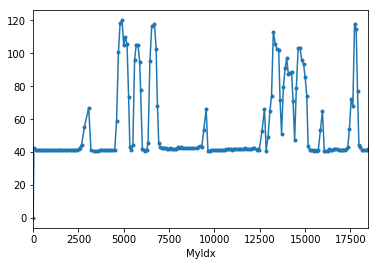

In [15]:
car = cldata[cldata['car_number']==1]
print(car['time_diff'].describe())
car['time_diff'][:total_laps].plot(marker='.')

In [16]:
cldata = make_cl_data(alldata)
cldata.to_csv(outputprefix + 'all_completed_laps_diff.csv')

cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
outputprefix

'2018-Indy500-'